### Parallel Query Expansion to Maximize Recall
The most common problem in the Agentic RAG pattern is the vocabulary-mismatch problem. Users rarely know the precise keywords or jargon used in a specialized knowledge base.

A simple query like “how to make models bigger and faster” might fail to retrieve a document that uses the technical terms “Mixture of Experts” and “FlashAttention”.

<p align="center">
  <img src="../../figures/parallel_query_expansion.png" width="1200">
</p>

Parallel Query Expansion is the architectural solution for this. Instead of taking the user query at face value, we first use a powerful LLM to brainstorm multiple, diverse ways to search for the same underlying information. This “pre-retrieval” step can generate a whole portfolio of search queries in parallel, such as:

- A hypothetical document (HyDE) that answers the question.
- Several decomposed sub-questions.
- A list of extracted keywords and entities.


By executing searches for all these queries in parallel and fusing the results, we dramatically increase the recall of our retrieval step, ensuring we find all the relevant pieces of evidence, even if they are described using different terminology.

We will build and compare a Simple RAG system with an Advanced RAG system using this pattern to prove that it produces a measurably more complete and accurate final answer.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        model="Qwen/Qwen3-4B-Instruct-2507"
    )
)

/Users/rachneet/projects/agents_experimental/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Creating the Knowledge Base

In [3]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 1. Create knowledge base documents with specific terminology
kb_docs = [
    "**Multi-headed Attention Mechanism**: The core component of the Transformer architecture is the multi-headed self-attention mechanism. It allows the model to weigh the importance of different words in the input sequence when processing a particular word, capturing contextual relationships. Each 'head' learns a different set of attention patterns in parallel.",
    "**Mixture of Experts (MoE) Layers**: To scale up model size without a proportional increase in computational cost, some large language models employ Mixture of Experts layers. In an MoE layer, a router network dynamically selects a small subset of 'expert' sub-networks to process each input token. This allows for a very high parameter count while keeping inference costs manageable.",
    "**FlashAttention Optimization**: A significant performance bottleneck in training large Transformers is the memory bandwidth required by the attention mechanism. FlashAttention is an I/O-aware algorithm that reorders the computation to reduce the number of read/write operations to high-bandwidth memory (HBM), leading to substantial speedups."
]

# 2. Create an embedding model and vector store
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_texts(kb_docs, embedding=embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

print(f"Knowledge Base created with {len(kb_docs)} documents.")

/var/folders/nm/srw3ygl55jbgpddqwgysqjpm0000gn/T/ipykernel_8776/4181891296.py:13: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


Knowledge Base created with 3 documents.


### Structured Data Models for Query Expansion
This Pydantic model defines the structure of our parallel query generation. The LLM will be instructed to populate all fields of this model in a single call.

In [12]:
from pydantic import BaseModel, Field
from typing import List

class ExpandedQueries(BaseModel):
    """A set of diverse, expanded queries to improve retrieval recall."""
    hypothetical_document: str = Field(description="A generated, paragraph-length hypothetical document that directly answers the user's question, which will be used for semantic search.")
    sub_questions: List[str] = Field(description="A list of 2-3 smaller, more specific questions that break down the original query.")
    keywords: List[str] = Field(description="A list of 3-5 core keywords and entities extracted from the user's query.")


### Building the RAG Systems

#### Simple RAG pipeline

In [13]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

generator_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert AI Architect. Answer the user's question based *only* on the following context. If the context does not contain the answer, say so. Be concise and accurate.\n\nContext:\n{context}"),
    ("human", "Question: {question}")
])

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

simple_rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | generator_prompt
    | llm
    | StrOutputParser()
)

### The Advanced RAG System (with Parallel Query Expansion)
This system uses a LangGraph graph to orchestrate the pre-retrieval query expansion step.

In [14]:
from typing import TypedDict, List, Optional
from langchain_core.documents import Document
from langchain_core.output_parsers import JsonOutputParser

class RAGGraphState(TypedDict):
    original_question: str
    expanded_queries: Optional[ExpandedQueries]
    retrieved_docs: List[Document]
    final_answer: str

# The Query Expansion Node
query_expansion_parser = JsonOutputParser(
    pydantic_object=ExpandedQueries
)
query_expansion_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a query expansion specialist. Your goal is to transform a user's question into a diverse set of search queries to maximize retrieval recall. Generate a hypothetical document, sub-questions, and keywords.\n\n{format_instructions}"),
    ("human", "Please expand the following question: {question}")
]).partial(format_instructions=query_expansion_parser.get_format_instructions())
query_expansion_chain = query_expansion_prompt | llm | query_expansion_parser

def query_expansion_node(state: RAGGraphState):
    print("--- [Expander] Generating parallel queries... ---")
    expanded_queries = query_expansion_chain.invoke({"question": state['original_question']})
    return {"expanded_queries": expanded_queries}

# The Retrieval Node (with parallel execution)
from concurrent.futures import ThreadPoolExecutor

def retrieval_node(state: RAGGraphState):
    print("--- [Retriever] Executing parallel searches... ---")
    all_queries = []
    expanded = state['expanded_queries']
    all_queries.append(expanded["hypothetical_document"])
    all_queries.extend(expanded["sub_questions"])
    all_queries.extend(expanded["keywords"])
    
    all_docs = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        # Run all retrievals in parallel
        results = executor.map(retriever.invoke, all_queries)
        for docs in results:
            all_docs.extend(docs)
    
    # Deduplicate documents based on page content
    unique_docs = {doc.page_content: doc for doc in all_docs}.values()
    print(f"--- [Retriever] Found {len(unique_docs)} unique documents from {len(all_queries)} queries. ---")
    return {"retrieved_docs": list(unique_docs)}

# The Generation Node
def generation_node(state: RAGGraphState):
    print("--- [Generator] Synthesizing final answer... ---")
    context = format_docs(state['retrieved_docs'])
    answer = (
        generator_prompt 
        | llm 
        | StrOutputParser()
    ).invoke({"context": context, "question": state['original_question']})
    return {"final_answer": answer}

### Assembling the Graph

In [15]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(RAGGraphState)

workflow.add_node("expand_queries", query_expansion_node)
workflow.add_node("retrieve_docs", retrieval_node)
workflow.add_node("generate_answer", generation_node)

workflow.set_entry_point("expand_queries")
workflow.add_edge("expand_queries", "retrieve_docs")
workflow.add_edge("retrieve_docs", "generate_answer")
workflow.add_edge("generate_answer", END)

advanced_rag_app = workflow.compile()
print("Advanced RAG graph compiled successfully.")

Advanced RAG graph compiled successfully.


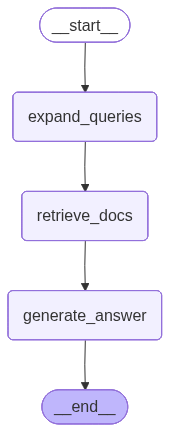

In [19]:
from IPython.display import Image
Image(advanced_rag_app.get_graph().draw_mermaid_png())

### Testing

In [16]:
user_query = "How do modern AI systems get so big and fast at the same time? I've heard about attention but I'm not sure how it's optimized."

In [10]:
print("--- [SIMPLE RAG] Retrieving documents...")
# We intercept the retrieval step to inspect the documents
simple_retrieved_docs = retriever.invoke(user_query)
print(f"--- [SIMPLE RAG] Documents Retrieved: {len(simple_retrieved_docs)}")
print("--- [SIMPLE RAG] Generating answer...\n")

simple_rag_answer = simple_rag_chain.invoke(user_query)

print("="*60)
print("                  SIMPLE RAG SYSTEM OUTPUT")
print("="*60 + "\n")
print(simple_rag_answer)

--- [SIMPLE RAG] Retrieving documents...
--- [SIMPLE RAG] Documents Retrieved: 3
--- [SIMPLE RAG] Generating answer...

                  SIMPLE RAG SYSTEM OUTPUT

Modern AI systems, particularly large language models, achieve both scale and efficiency through a combination of advanced architectural designs and optimizations:

1. **Multi-headed Attention**: The core of the Transformer architecture, multi-headed self-attention allows the model to weigh the importance of different words when processing a given word. Each "head" learns different patterns in parallel, enabling the model to capture diverse contextual relationships efficiently.

2. **Mixture of Experts (MoE)**: To scale up model size without proportionally increasing computational cost, MoE layers dynamically route each input token to a small subset of "expert" sub-networks. This enables massive parameter counts while keeping inference costs manageable.

3. **FlashAttention Optimization**: A key performance bottleneck in tra

In [18]:
inputs = {"original_question": user_query}
advanced_rag_result = None
for output in advanced_rag_app.stream(inputs, stream_mode="values"):
    advanced_rag_result = output

print("="*60)
print("                 ADVANCED RAG SYSTEM OUTPUT")
print("="*60 + "\n")
print(advanced_rag_result['final_answer'])

--- [Expander] Generating parallel queries... ---
--- [Retriever] Executing parallel searches... ---
--- [Retriever] Found 3 unique documents from 9 queries. ---
--- [Generator] Synthesizing final answer... ---
                 ADVANCED RAG SYSTEM OUTPUT

Modern AI systems, especially large language models, achieve both size and speed through a combination of advanced architectural designs and optimization techniques:

1. **Multi-headed Attention**: At the core of models like Transformers is the multi-headed self-attention mechanism. This allows the model to simultaneously attend to different aspects of the input (e.g., syntax, semantics, context) by learning multiple attention patterns in parallel. Each "head" captures different types of relationships between words, enabling the model to understand context more deeply and efficiently.

2. **FlashAttention Optimization**: A major bottleneck in attention computation is memory bandwidth. FlashAttention is an I/O-aware algorithm that reor